PHÂN TÍCH CỔ PHIẾU VINAMILK (VNM) VÀ DỰ BÁO XU HƯỚNG

Đầu tiên import các thư viện cần thiết

In [1]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
import warnings
warnings.filterwarnings('ignore') #cảnh báo và tắt các cảnh báo
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

Sử dụng thư viện pandas để đọc dữ liệu từ tệp CSV có tên "DATA_VNM.csv" và tạo một DataFrame mới với tên df. DataFrame này chứa thông tin về cổ phiếu có mã 'VNM', bao gồm các cột như Ngày, Giá mở cửa, Giá đóng cửa, Khối lượng (KL), Thay đổi (%) và các thông tin khác liên quan đến giá cổ phiếu theo từng ngày.

df = df.drop(columns=["KL", "% Thay đổi"]): Đoạn này sử dụng phương thức .drop() để loại bỏ hai cột có tên "KL" (Khối lượng) và "% Thay đổi" khỏi DataFrame df. Cột "KL" chứa thông tin về khối lượng giao dịch và cột "% Thay đổi" chứa thông tin về tỷ lệ thay đổi giá cổ phiếu trong một khoảng thời gian cụ thể.

Và cuối cùng in ra DataFrame 'df'

In [2]:
equity = 'VNM'
df = pd.read_csv("DATA_VNM.csv")
# Xóa hai dòng "KL" và "Thay đổi %" từ DataFrame dataSet
df = df.drop(columns=["KL", "% Thay đổi"])
# Hiển thị lại DataFrame sau khi xóa
print(df)

            Ngày  Đóng cửa    Mở cửa  Cao nhất Thấp nhất
0     21/07/2023  73,500.0  72,500.0  75,000.0  72,400.0
1     20/07/2023  72,700.0  72,600.0  72,900.0  72,300.0
2     19/07/2023  72,600.0  72,500.0  73,000.0  72,400.0
3     18/07/2023  72,400.0  72,500.0  72,600.0  72,200.0
4     17/07/2023  72,300.0  73,000.0  73,600.0  72,200.0
...          ...       ...       ...       ...       ...
2500  16/07/2013  96,528.0  95,139.0  97,222.0  95,139.0
2501  15/07/2013  95,139.0  95,139.0  95,833.0  94,444.0
2502  12/07/2013  95,139.0  94,444.0  95,139.0  93,750.0
2503  11/07/2013  94,444.0  94,444.0  95,139.0  93,750.0
2504  10/07/2013  94,444.0  95,139.0  95,833.0  94,444.0

[2505 rows x 5 columns]


Tiếp theo tiến hành mô tả dữ liệu

In [3]:
#định dạng cấu trúc thời gian
df["Ngày"] = pd.to_datetime(df.Ngày,format="%d/%m/%Y")

In [4]:
#kích thước dữ liệu
df.shape

(2505, 5)

In [5]:
#xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Ngày       2505 non-null   datetime64[ns]
 1   Đóng cửa   2505 non-null   object        
 2   Mở cửa     2505 non-null   object        
 3   Cao nhất   2505 non-null   object        
 4   Thấp nhất  2505 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 98.0+ KB


In [6]:
#mô tả bộ dữ liệu
df.describe()

,Ngày,Đóng cửa,Mở cửa,Cao nhất,Thấp nhất
count,2505,2505,2505,2505,2505
unique,2505,1250,1223,1300,1271
top,2023-07-21 00:00:00,"96,528.0","97,222.0","98,611.0","96,528.0"
freq,1,34,33,34,42
first,2013-07-10 00:00:00,NaN,NaN,NaN,NaN
last,2023-07-21 00:00:00,NaN,NaN,NaN,NaN


Bước tiếp theo là Tiền xử lý dữ liệu

from matplotlib.dates import YearLocator, DateFormatter, MonthLocator: Đoạn này import các lớp YearLocator, DateFormatter và MonthLocator từ module matplotlib.dates. Các lớp này sẽ được sử dụng để định dạng trục thời gian trên đồ thị.

df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y'): Dòng này chuyển đổi cột "Ngày" từ định dạng chuỗi thành định dạng thời gian (datetime) sử dụng hàm pd.to_datetime(). Định dạng thời gian trong trường hợp này được xác định là '%d/%m/%Y' (ngày/tháng/năm).

df = df.sort_values(by='Ngày'): Đoạn này sắp xếp lại DataFrame theo thứ tự thời gian bằng cách sử dụng cột "Ngày" làm tiêu chí sắp xếp.

price_columns = ['Đóng cửa', 'Mở cửa', 'Cao nhất', 'Thấp nhất']: Danh sách các cột chứa thông tin về giá cổ phiếu.

Vòng lặp for col in price_columns:: Vòng lặp này kiểm tra xem các cột giá cổ phiếu có kiểu dữ liệu số thực hay không. Nếu chưa phải số thực, nó sẽ loại bỏ các dấu ',' (nếu có) và chuyển đổi các giá trị thành số thực (float).

df['Năm'] = df['Ngày'].dt.year: Tạo một cột mới trong DataFrame chứa thông tin về năm từ cột "Ngày".

Và cuối cùng trực quan dữ liệu giá đóng cửa bằng biểu đồ

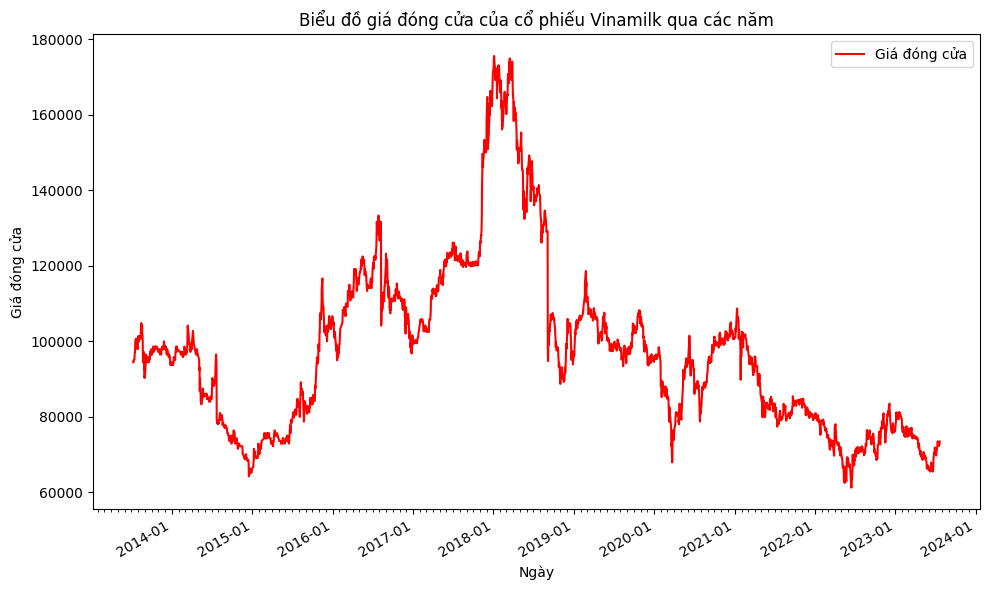

In [7]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi

# Chuyển đổi cột "Ngày" sang dạng datetime
df['Ngày'] = pd.to_datetime(df['Ngày'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Ngày')

# Kiểm tra và xử lý cột dữ liệu giá nếu chưa là số thực
price_columns = ['Đóng cửa', 'Mở cửa', 'Cao nhất', 'Thấp nhất']
for col in price_columns:
    if not pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Năm'] = df['Ngày'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 6))
plt.plot(df['Ngày'], df['Đóng cửa'], label='Giá đóng cửa', color='red')
plt.xlabel('Ngày')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của cổ phiếu Vinamilk qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
months = MonthLocator()
yearsFmt = DateFormatter('%Y-%m')  # Định dạng thêm tháng (%m) vào năm (%Y)
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

# Xoay ngày tháng để tránh chồng chéo
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


Tạo một DataFrame mới df1 chỉ chứa thông tin về cột "Ngày" và "Đóng cửa" từ DataFrame ban đầu df, sau đó biến cột "Ngày" thành chỉ số của DataFrame, loại bỏ cột "Ngày" khỏi DataFrame df1, và cuối cùng hiển thị DataFrame df1 sau khi đã thực hiện các thay đổi này.

In [8]:
df1 = pd.DataFrame(df,columns=['Ngày','Đóng cửa'])
df1.index = df1.Ngày
df1.drop('Ngày',axis=1,inplace=True)
df1

,Đóng cửa
Ngày,
2013-07-10,94444.0
2013-07-11,94444.0
2013-07-12,95139.0
2013-07-15,95139.0
2013-07-16,96528.0
...,...
2023-07-17,72300.0
2023-07-18,72400.0
2023-07-19,72600.0


Tiến hành xây dựng mô hình LSTM 

data = df1.values: Dòng này chuyển đổi DataFrame df1 thành một mảng NumPy bằng cách sử dụng thuộc tính .values. Mảng NumPy này chứa các giá trị từ DataFrame df1 mà chúng ta muốn sử dụng để huấn luyện và kiểm tra mô hình.

train_data = data[:1500]: Dòng này chọn 1500 dòng đầu tiên từ mảng data và gán chúng cho biến train_data. Điều này có nghĩa là tập dữ liệu huấn luyện sẽ chứa 1500 dòng đầu tiên của dữ liệu.

test_data = data[1500:]: Dòng này chọn tất cả các dòng từ mảng data bắt đầu từ dòng thứ 1500 và gán chúng cho biến test_data. Điều này có nghĩa là tập dữ liệu kiểm tra sẽ chứa các dòng từ dòng thứ 1500 trở đi của dữ liệu.

Sau khi thực hiện ba dòng code trên, sẽ có hai biến train_data và test_data, mỗi biến chứa một phần tương ứng của dữ liệu gốc. Tập dữ liệu train_data sẽ được sử dụng để huấn luyện mô hình và tập dữ liệu test_data sẽ được sử dụng để kiểm tra và đánh giá mô hình đã huấn luyện trên dữ liệu mới.

In [9]:
#chia tập dữ liệu
data = df1.values
train_data = data[:1500]
test_data = data[1500:]

In [10]:
data

array([[94444.],
       [94444.],
       [95139.],
       ...,
       [72600.],
       [72700.],
       [73500.]])

sc = MinMaxScaler(feature_range=(0, 1)): Đoạn này tạo một đối tượng sc của lớp MinMaxScaler từ thư viện sklearn.preprocessing. Lớp này thực hiện chuẩn hóa dữ liệu bằng cách chuyển đổi các giá trị thành một khoảng giữa hai giá trị đã xác định (feature_range). Trong trường hợp này, khoảng giữa hai giá trị được chọn là từ 0 đến 1.

sc_train = sc.fit_transform(data): Dòng này sử dụng đối tượng sc để thực hiện chuẩn hóa dữ liệu trên mảng data. Phương thức fit_transform() thực hiện quá trình huấn luyện sc trên dữ liệu và sau đó chuyển đổi dữ liệu theo phương pháp Min-Max Scaling. Kết quả được lưu vào biến sc_train.

Sau khi thực hiện các dòng lệnh này, sẽ có một mảng NumPy sc_train chứa dữ liệu đã được chuẩn hóa theo phương pháp Min-Max Scaling, với giá trị các biến nằm trong khoảng từ 0 đến 1. Điều này đảm bảo rằng các biến trong tập dữ liệu có cùng phạm vi và đơn vị, giúp cho việc huấn luyện mô hình có hiệu suất tốt hơn.

In [11]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)


window_size = 50: Định nghĩa kích thước của cửa trượt (sliding window). Trong trường hợp này, ta sẽ xem xét 50 ngày gần nhất để dự đoán giá đóng cửa của ngày tiếp theo.

x_train, y_train = [], []: Khởi tạo hai danh sách rỗng x_train và y_train. x_train sẽ chứa dữ liệu đầu vào của mô hình (dãy các ngày gần nhất), và y_train sẽ chứa giá trị mục tiêu (giá đóng cửa của ngày hôm sau).

Vòng lặp for i in range(window_size, len(train_data)):: Vòng lặp này duyệt qua các chỉ số trong tập dữ liệu huấn luyện, bắt đầu từ vị trí window_size (50) và kết thúc ở độ dài của tập dữ liệu huấn luyện.

x_train.append(sc_train[i - window_size:i, 0]): Trong mỗi vòng lặp, dùng cửa trượt để lấy dãy 50 ngày gần nhất từ dữ liệu đã chuẩn hóa (sc_train) và thêm nó vào danh sách x_train.

y_train.append(sc_train[i, 0]): Cũng trong mỗi vòng lặp, lấy giá đóng cửa của ngày hôm sau (ngày 51) từ dữ liệu đã chuẩn hóa (sc_train) và thêm nó vào danh sách y_train.

x_train = np.array(x_train) và y_train = np.array(y_train): Chuyển đổi danh sách x_train và y_train thành các mảng NumPy để tiện cho việc làm việc với mô hình.

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) và y_train = np.reshape(y_train, (y_train.shape[0], 1)): Thay đổi hình dạng của dữ liệu để phù hợp với mô hình LSTM (Long Short-Term Memory) yêu cầu đầu vào có kích thước (số mẫu, độ dài chuỗi, số chiều đặc trưng).

print("Shape of x_train:", x_train.shape) và print("Shape of y_train:", y_train.shape): In ra thông tin về hình dạng của x_train và y_train để kiểm tra.

Tóm lại, các dòng lệnh này thực hiện tạo dữ liệu huấn luyện sử dụng sliding window, trong đó mỗi mẫu huấn luyện bao gồm 50 ngày gần nhất và mục tiêu dự đoán là giá đóng cửa của ngày hôm sau. Dữ liệu này được chuẩn hóa và điều chỉnh hình dạng để phù hợp với mô hình LSTM.






In [12]:
# Tạo dữ liệu huấn luyện với sliding window
window_size = 50
x_train, y_train = [], []

for i in range(window_size, len(train_data)):
    x_train.append(sc_train[i - window_size:i, 0])  # Lấy 50 giá đóng cửa liên tục
    y_train.append(sc_train[i, 0])  # Lấy giá đóng cửa ngày hôm sau

# Chuyển thành numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))
# In shape của x_train và y_train để đảm bảo
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)


Shape of x_train: (1450, 50, 1)
Shape of y_train: (1450, 1)


Tiến hành xây dựng và huấn luyện mô hình

from keras.optimizers import Adam và from keras.callbacks import ModelCheckpoint: Dòng này import các lớp Adam từ module keras.optimizers và ModelCheckpoint từ module keras.callbacks. Adam là một thuật toán tối ưu hóa và ModelCheckpoint cho phép lưu mô hình tốt nhất trong quá trình huấn luyện.

Tạo tối ưu hóa Adam với learning rate thấp hơn:

new_learning_rate = 0.001: Điều chỉnh learning rate cho tối ưu hóa Adam tùy theo nhu cầu. Learning rate quyết định tốc độ học của mô hình trong quá trình huấn luyện.
optimizer = Adam(learning_rate=new_learning_rate): Tạo một tối ưu hóa Adam mới với learning rate đã chỉ định.
Xây dựng lại mô hình:

model = Sequential(): Tạo một mô hình tuần tự (sequential) sử dụng Keras.
model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True)): Thêm một lớp LSTM với 128 đơn vị vào mô hình. Lớp này có đầu vào là số lượng thời điểm (x_train.shape[1]) và số chiều đặc trưng (1), và sẽ trả về chuỗi đầu ra thay vì đầu ra duy nhất của lớp LSTM.
model.add(LSTM(units=64)): Thêm một lớp LSTM khác với 64 đơn vị vào mô hình. Lớp này không trả về chuỗi đầu ra, nên sử dụng return_sequences=False (mặc định).
model.add(Dropout(0.5)): Thêm một lớp Dropout với tỷ lệ dropout là 0.5 để tránh overfitting.
model.add(Dense(1)): Thêm một lớp Fully Connected (Dense) với 1 đơn vị đầu ra.
model.compile(optimizer=optimizer, loss='mean_squared_error'): Biên dịch mô hình với tối ưu hóa và hàm mất mát (loss function). Trong trường hợp này, mô hình sẽ sử dụng tối ưu hóa Adam và mất mát được tính bằng sai số bình phương trung bình (mean squared error).

save_model = "save_model.hdf5" và best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto'): Xác định tên file để lưu mô hình tốt nhất trong quá trình huấn luyện. Đối tượng ModelCheckpoint sẽ lưu mô hình dựa trên tham số kiểm soát monitor (trong trường hợp này là 'loss'), và chỉ lưu mô hình tốt nhất (save_best_only=True).

model.fit(x_train, y_train, epochs=120, batch_size=50, verbose=2, callbacks=[best_model]): Huấn luyện mô hình với dữ liệu huấn luyện x_train và y_train. Các thông số:

epochs=120: Số lượng vòng lặp huấn luyện.
batch_size=50: Kích thước của các batch dữ liệu trong mỗi vòng lặp.
verbose=2: Cách hiển thị thông tin huấn luyện trên màn hình (2: hiển thị tiến trình tương đối chi tiết).
callbacks=[best_model]: Sử dụng đối tượng best_model để lưu mô hình tốt nhất.
print("Done Training Model"): In ra thông báo khi quá trình huấn luyện mô hình hoàn tất.

Tóm lại, các dòng lệnh này thực hiện xây dựng và huấn luyện mô hình dự đoán giá cổ phiếu sử dụng mạng LSTM, với tối ưu hóa Adam, lưu mô hình tốt nhất trong quá trình huấn luyện, và hiển thị thông tin huấn luyện trên màn hình.

In [13]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

# Tạo một tối ưu hóa Adam với learning rate thấp hơn
new_learning_rate = 0.001  # Điều chỉnh learning rate tùy theo nhu cầu
optimizer = Adam(learning_rate=new_learning_rate)

# Xây dựng lại mô hình với tối ưu hóa mới
model = Sequential()

model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer=optimizer, loss='mean_squared_error')
save_model = "save_model.hdf5"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')  
model.fit(x_train, y_train, epochs=120, batch_size=50, verbose=2, callbacks=[best_model])
print("Done Training Model")


Epoch 1/120

Epoch 1: loss improved from inf to 0.02405, saving model to save_model.hdf5
29/29 - 4s - loss: 0.0240 - 4s/epoch - 126ms/step
Epoch 2/120

Epoch 2: loss improved from 0.02405 to 0.00591, saving model to save_model.hdf5
29/29 - 2s - loss: 0.0059 - 2s/epoch - 57ms/step
Epoch 3/120

Epoch 3: loss improved from 0.00591 to 0.00577, saving model to save_model.hdf5
29/29 - 2s - loss: 0.0058 - 2s/epoch - 57ms/step
Epoch 4/120

Epoch 4: loss improved from 0.00577 to 0.00501, saving model to save_model.hdf5
29/29 - 2s - loss: 0.0050 - 2s/epoch - 59ms/step
Epoch 5/120

Epoch 5: loss improved from 0.00501 to 0.00457, saving model to save_model.hdf5
29/29 - 2s - loss: 0.0046 - 2s/epoch - 58ms/step
Epoch 6/120

Epoch 6: loss did not improve from 0.00457
29/29 - 2s - loss: 0.0050 - 2s/epoch - 56ms/step
Epoch 7/120

Epoch 7: loss did not improve from 0.00457
29/29 - 2s - loss: 0.0047 - 2s/epoch - 57ms/step
Epoch 8/120

Epoch 8: loss improved from 0.00457 to 0.00444, saving model to save_m

29/29 - 2s - loss: 0.0015 - 2s/epoch - 55ms/step
Epoch 70/120

Epoch 70: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0014 - 2s/epoch - 54ms/step
Epoch 71/120

Epoch 71: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0016 - 2s/epoch - 53ms/step
Epoch 72/120

Epoch 72: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0015 - 2s/epoch - 53ms/step
Epoch 73/120

Epoch 73: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0013 - 2s/epoch - 53ms/step
Epoch 74/120

Epoch 74: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0015 - 2s/epoch - 53ms/step
Epoch 75/120

Epoch 75: loss did not improve from 0.00133
29/29 - 2s - loss: 0.0015 - 2s/epoch - 63ms/step
Epoch 76/120

Epoch 76: loss improved from 0.00133 to 0.00126, saving model to save_model.hdf5
29/29 - 2s - loss: 0.0013 - 2s/epoch - 58ms/step
Epoch 77/120

Epoch 77: loss did not improve from 0.00126
29/29 - 2s - loss: 0.0014 - 2s/epoch - 55ms/step
Epoch 78/120

Epoch 78: loss did not improve from 0.00126


y_train = sc.inverse_transform(y_train): Dòng này đảo ngược quá trình chuẩn hóa trên dữ liệu đích huấn luyện (y_train). Điều này chuyển đổi lại từ dữ liệu chuẩn hóa sang đơn vị gốc, để có thể so sánh dự đoán của mô hình với giá thực tế.

final_model = load_model('save_model.hdf5'): Dòng này tải mô hình đã lưu (mô hình tốt nhất trong quá trình huấn luyện) bằng cách sử dụng hàm load_model() từ module keras.models.

y_train_predict = final_model.predict(x_train): Sử dụng mô hình đã tải, dự đoán giá đóng cửa của tập dữ liệu huấn luyện x_train.

y_train_predict = sc.inverse_transform(y_train_predict): Tương tự như bước 1, dòng này đảo ngược quá trình chuẩn hóa trên dự đoán y_train_predict. Điều này chuyển đổi lại từ dữ liệu chuẩn hóa sang đơn vị gốc, để có thể so sánh dự đoán của mô hình với giá thực tế.

Sau khi thực hiện các dòng lệnh này, bạn sẽ có hai mảng y_train (giá thực tế) và y_train_predict (giá dự đoán). Các mảng này cho phép bạn so sánh giữa dự đoán của mô hình và giá thực tế để đánh giá hiệu suất của mô hình trên tập dữ liệu huấn luyện.

In [14]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model=load_model('save_model.hdf5')
y_train_predict=final_model.predict(x_train)
y_train_predict=sc.inverse_transform(y_train_predict) #giá dự đoán

46/46 [==============================] - 1s 14ms/step


Sử dụng mô hình

test = df1[len(train_data)-window_size:].values: Dòng này chọn tập dữ liệu kiểm tra từ DataFrame df1 bắt đầu từ vị trí ngay sau tập dữ liệu huấn luyện, có độ dài bằng kích thước cửa trượt (window_size). Mục đích là để có tập dữ liệu kiểm tra có cùng định dạng với tập dữ liệu huấn luyện.

test = test.reshape(-1,1): Chuyển đổi mảng test thành một mảng 2D, để phù hợp với chuẩn hóa dữ liệu.

sc_test = sc.transform(test): Chuẩn hóa dữ liệu kiểm tra bằng cách sử dụng cùng đối tượng MinMaxScaler (sc) đã được huấn luyện trước đó trên tập dữ liệu huấn luyện.

Tạo x_test:

x_test = []: Khởi tạo danh sách rỗng x_test để chứa dữ liệu đầu vào của tập dữ liệu kiểm tra.
Vòng lặp for i in range(window_size, test.shape[0]):: Vòng lặp duyệt qua từng dòng trong tập dữ liệu kiểm tra, bắt đầu từ vị trí có thể tạo cửa trượt.
x_test.append(sc_test[i - window_size:i, 0]): Trong mỗi vòng lặp, thêm dãy 50 ngày gần nhất từ dữ liệu kiểm tra đã chuẩn hóa vào danh sách x_test.
x_test = np.array(x_test): Chuyển danh sách x_test thành mảng NumPy để tiện cho việc sử dụng với mô hình.

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)): Điều chỉnh hình dạng của x_test để phù hợp với mô hình LSTM.

y_test = data[1500:]: Lấy dữ liệu giá thực tế của tập dữ liệu kiểm tra, bắt đầu từ vị trí 1500 (sau tập dữ liệu huấn luyện).

y_test_predict = final_model.predict(x_test): Sử dụng mô hình đã tải (final_model), dự đoán giá đóng cửa của tập dữ liệu kiểm tra x_test.

y_test_predict = sc.inverse_transform(y_test_predict): Đảo ngược chuẩn hóa trên dự đoán y_test_predict để chuyển đổi lại từ dữ liệu chuẩn hóa sang đơn vị gốc.

Sau khi thực hiện các dòng lệnh này, bạn sẽ có tập dữ liệu kiểm tra chuẩn hóa (sc_test), tập dữ liệu đầu vào kiểm tra đã được điều chỉnh hình dạng cho mô hình (x_test), và hai mảng y_test (giá thực) và y_test_predict (giá dự đoán). Các mảng này cho phép bạn so sánh giữa giá thực tế và giá dự đoán trên tập dữ liệu kiểm tra để đánh giá hiệu suất của mô hình.

In [15]:
#xử lý dữ liệu test
test = df1[len(train_data)-window_size:].values
test = test.reshape(-1,1)
sc_test = sc.transform(test)

x_test = []
for i in range(window_size,test.shape[0]):
    x_test.append(sc_test[i-window_size:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1500:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

32/32 [==============================] - 0s 12ms/step


Độ chính xác của mô hình

Tạo biểu đồ so sánh giữa giá thực tế và giá dự đoán trên tập dữ liệu huấn luyện và tập dữ liệu kiểm tra.

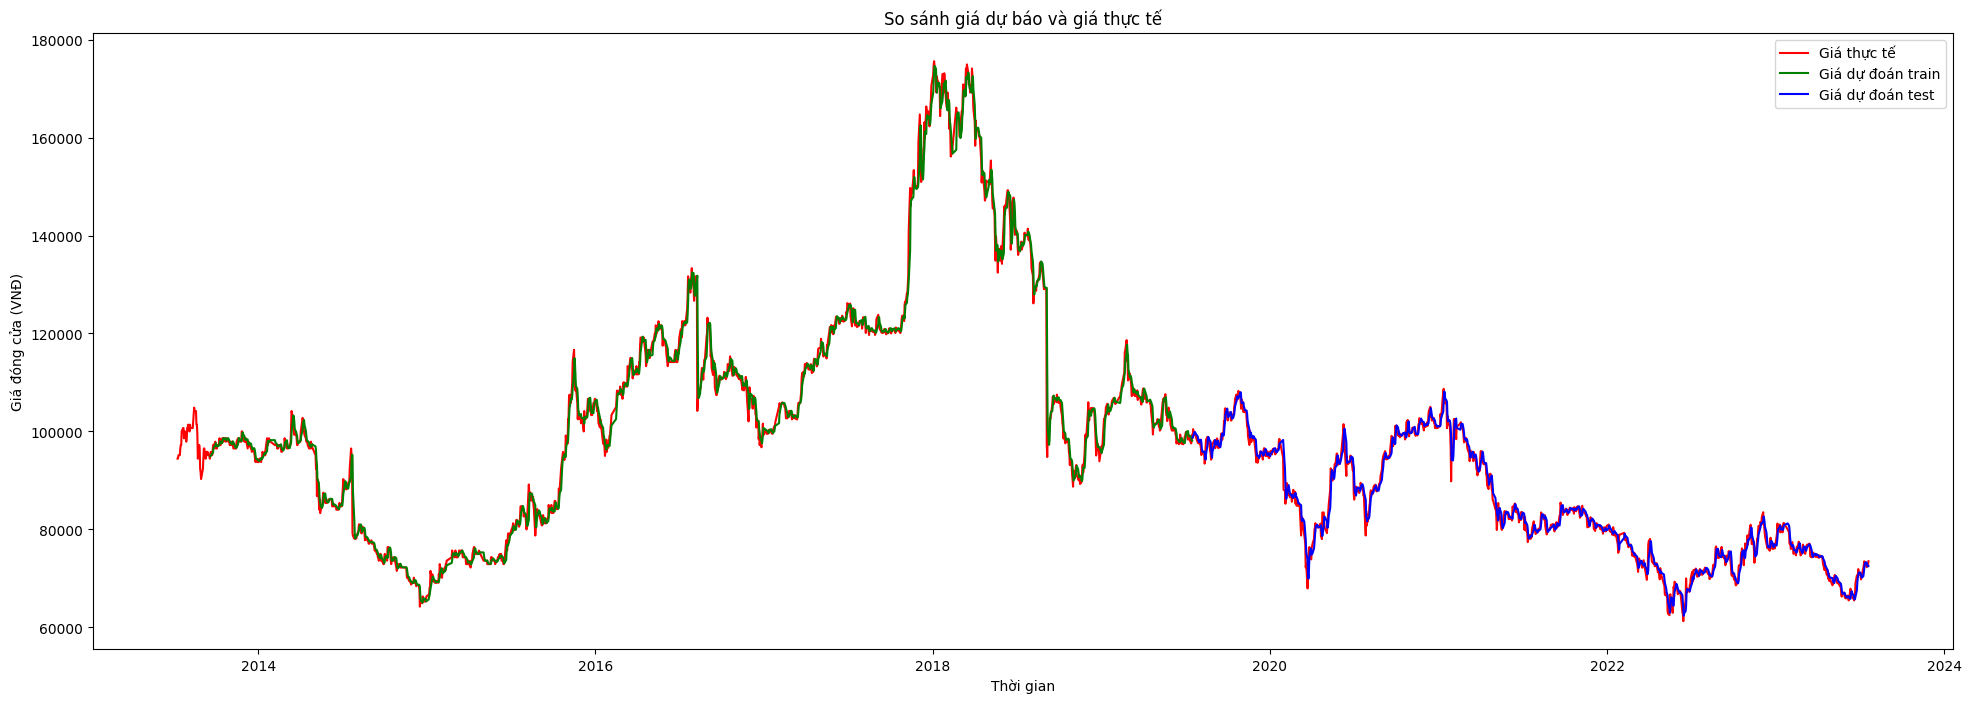

In [16]:
#lập biểu đồ so sánh
train_data1 = df1[window_size:1500]
test_data1 = df1[1500:]

plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

Đánh giá hiệu suất của mô hình dự đoán giá cổ phiếu trên tập dữ liệu huấn luyện bằng chỉ số R-Squared, MAE-Mean Absolute Error và MAPE

In [17]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9916516731227938
Sai số tuyệt đối trung bình trên tập train (VNĐ): 1279.3979822198273
Phần trăm sai số tuyệt đối trung bình tập train: 0.01190189080334587


In [18]:
train_data1

,Đóng cửa,Dự đoán
Ngày,,
2013-09-19,95139.0,94957.468750
2013-09-20,95833.0,95005.375000
2013-09-23,95139.0,95484.507812
2013-09-24,95833.0,95522.984375
2013-09-25,97222.0,95739.382812
...,...,...
2019-07-11,99133.0,98981.742188
2019-07-12,98183.0,99123.796875
2019-07-15,97549.0,98789.062500


Đánh giá hiệu suất của mô hình dự đoán giá cổ phiếu trên tập dữ liệu kiểm tra bằng các chỉ số tương tự như trên tập huấn luyện.

In [19]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9820881326375513
Sai số tuyệt đối trung bình trên tập test (VNĐ): 1089.3573919465173
Phần trăm sai số tuyệt đối trung bình tập test: 0.013137707633795634


In [20]:
test_data1

,Đóng cửa,Dự đoán
Ngày,,
2019-07-18,98658.0,98754.109375
2019-07-19,100479.0,98966.492188
2019-07-22,99371.0,99817.828125
2019-07-23,99291.0,99891.921875
2019-07-24,99450.0,99674.554688
...,...,...
2023-07-17,72300.0,73283.460938
2023-07-18,72400.0,72866.500000
2023-07-19,72600.0,72523.257812


Thử dự đoán giá tương lai và so sánh với giá ngày cuối

Thực hiện các bước sau để dự đoán giá cho ngày kế tiếp và thêm dữ liệu dự đoán vào DataFrame:

next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1): Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu bằng cách thêm 1 ngày (pd.Timedelta(days=1)).

next_date = pd.to_datetime(next_date): Chuyển ngày kế tiếp sang định dạng datetime.

next_closing_price = np.array([df['Đóng cửa'].iloc[-1]]): Lấy giá trị đóng cửa của ngày cuối cùng trong tập dữ liệu và chuyển thành mảng NumPy.

next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1)): Chuẩn hóa giá trị của ngày cuối cùng bằng cách sử dụng sc (đã được sử dụng trong quá trình chuẩn hóa dữ liệu huấn luyện).

x_next = np.array([sc_train[-window_size:, 0]]): Lấy 50 giá đóng cửa gần nhất để dự đoán ngày kế tiếp.

x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1)): Điều chỉnh hình dạng của x_next để phù hợp với mô hình.

y_next_predict = final_model.predict(x_next): Sử dụng mô hình đã huấn luyện để dự đoán giá cho ngày kế tiếp.

y_next_predict = sc.inverse_transform(y_next_predict): Đảo ngược chuẩn hóa trên dự đoán để chuyển đổi lại từ dữ liệu chuẩn hóa sang đơn vị gốc.

Tạo DataFrame mới và thêm vào dữ liệu dự đoán cho ngày kế tiếp:

df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]}): Tạo DataFrame mới chứa ngày kế tiếp và giá dự đoán cho ngày đó.
df1 = pd.concat([df1, df_next]): Kết hợp DataFrame gốc df1 với DataFrame df_next để thêm dữ liệu dự đoán cho ngày kế tiếp.
Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp:

Tương tự như các bước trước, tạo một biểu đồ để so sánh giá thực tế, giá dự đoán trên tập huấn luyện và tập kiểm tra, và thêm điểm dự đoán cho ngày kế tiếp.
Mục đích của đoạn mã này là để thực hiện dự đoán giá cho ngày tiếp theo sau khi mô hình đã được huấn luyện và thêm dữ liệu dự đoán này vào DataFrame để có thể hiển thị trên biểu đồ so sánh.






1/1 [==============================] - 0s 22ms/step


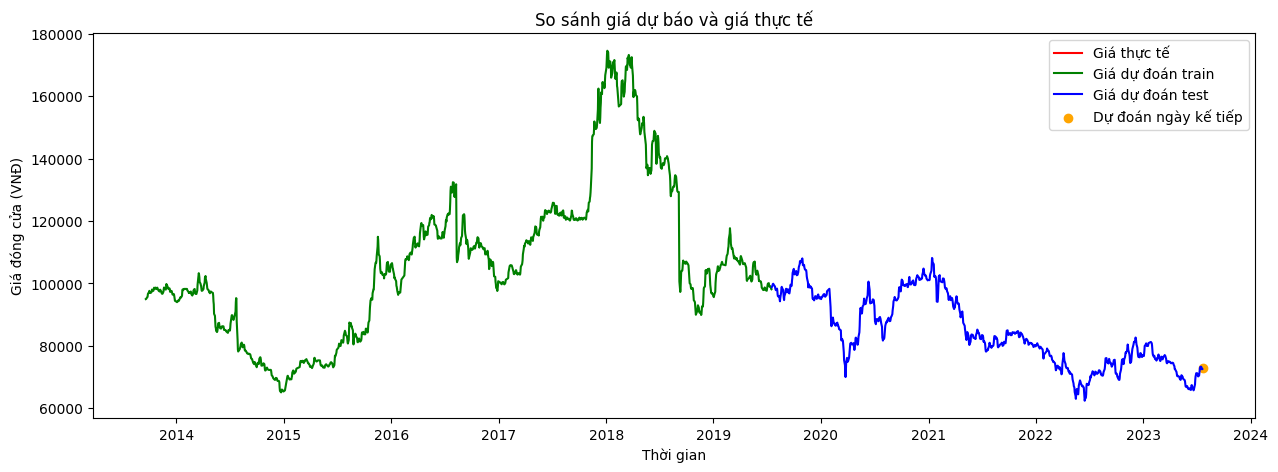

In [21]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Ngày'].iloc[-1] + pd.Timedelta(days=1)
# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Đóng cửa'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-window_size:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Ngày': [next_date], 'Đóng cửa': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Ngày'], df1['Đóng cửa'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


Cuối cùng tạo một DataFrame chứa các thông tin so sánh giữa giá dự đoán cho ngày tiếp theo và giá của ngày cuối cùng trong tập dữ liệu gốc.

Mục đích của đoạn mã này là để so sánh giá dự đoán cho ngày tiếp theo với giá thực tế của ngày đó, để đánh giá khả năng dự đoán của mô hình trong tương lai.

In [22]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Đóng cửa'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

        Ngày   Giá dự đoán  Giá ngày trước
0 2023-07-22  72971.609375         73500.0
